In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
mpl.rcParams['font.size'] = 10

import matplotlib.pyplot as plt

import pyemu
import shutil

In [2]:
# Construct the original model
org_model_ws =  os.path.join('calib', 'model')


if not os.path.exists(org_model_ws):
    os.makedirs(org_model_ws)

import disolv
convertFEC=False

disolv.run(org_model_ws, org_model_ws, calibrate=False, convertFEC=convertFEC,
           method='SLSQP')

No automatic calibration
Equation will be solved at times 0.02, 0.2, 0.5, 1.0, 1.5, 2.0, 3.0, 6.0
8 measured profiles have been found
RMSE: 155.04838473344253


In [3]:
# prepare calibration datase
# pest template folder
template_ws = os.path.join('calib',"pestpp_template")

In [4]:
# instantiate a PstFrom class
pf = pyemu.utils.PstFrom(original_d=org_model_ws, new_d=template_ws,
                 remove_existing=True, longnames=True)

# add imports
pf.extra_py_imports = ['disolv','pandas', 'os']

# add commands to model run
pf.mod_sys_cmds.append("python run_model.py")

# dont calibrate in/out flows directly
# calibrate a total flow and then have fractions; the fraction must add up to 1.0
# scale the fractions by the maximum fration value

# prepapre an input file for total flow; this file will be parameterized by PEST and used by run_model.py to update flows.csv
total_flow = 0.7766
pd.DataFrame([total_flow], columns=['Flow [L^3 T^-1]']).to_csv(os.path.join(template_ws, 'total_flow.csv'))

# prepare a flow fraction csv file; this file will be parameterized by PEST and used by run_model.py to update flows.csv
flows = pd.read_csv(os.path.join(template_ws, 'flows.csv'))

for col in [1,2]:
    flows.iloc[:,col] = 0.5*flows.iloc[:,col]/abs(flows.iloc[:,col].max())

flows.to_csv(os.path.join(template_ws, 'flows_frac.csv'), index=False)

# flow parameters
pf.add_parameters(filenames='flows_frac.csv', mfile_skip=1,
                par_style='direct',
                par_type="grid",
                pargp=['in_flows', 'out_flows'], 
                upper_bound = 1e8, lower_bound=1e-8,
                index_cols=[0], use_cols=[1,2],
                transform='log',
                par_name_base=['in', 'out'])

# total flow parameter
pf.add_parameters(filenames='total_flow.csv', mfile_skip =1, 
                par_style='direct',
                par_type="constant",
                pargp='tot', 
                upper_bound = 1000, lower_bound=0,
                index_cols=[0], use_cols=[1],
                transform='log',
                par_name_base='tot')


# model parameters
pf.add_parameters(filenames='in.csv', mfile_skip=1,
                par_style='direct',
                par_type="grid",
                pargp='model', 
                upper_bound = 10, lower_bound=-10,
                index_cols=[0], use_cols=[1],
                transform='fixed')


# build the obs file
sim = pd.read_csv(os.path.join(org_model_ws, 'profiles.csv'))
meas = pd.read_csv(os.path.join(org_model_ws, 'measuredprofiles.csv'))

obs = sim.copy()
obs.iloc[:, 1:] = 1e30

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

x=0
for col in range(int(len(meas.columns)/2)):
    meas_col = col+x
    x+=1
    for row in range(len(meas.iloc[:,col])):
        meas_depth = meas.iloc[row, meas_col]
        sim_depth_idx = find_nearest(sim.iloc[:,0], meas_depth)

        obs.iloc[sim_depth_idx, col+1] = meas.iloc[row, meas_col+1]

obs.to_csv(os.path.join(template_ws, 'profiles.csv'), index=None)

# get obsg names fromtimes
obsgp = pd.read_csv(os.path.join(template_ws, 'output_times.csv')).iloc[:,0].values
obsgp = ['prof_'+str(i) for i in obsgp]

pf.add_observations(filename='profiles.csv', ofile_skip=1, ofile_sep=None, rebuild_pst=False, zone_array=None, includes_header=False,
                    index_cols=[0], obsgp=obsgp)

# add flows as observations/forecasts
pf.add_observations(filename='flows.csv', ofile_skip=1, ofile_sep=None, rebuild_pst=False, zone_array=None, includes_header=False,
                    index_cols=[0],use_cols=[1,2], obsgp=['flow_in', 'flow_out'], prefix='flow_' )


pst = pf.build_pst()

# tidy up parameters
par = pst.parameter_data

# set scale for out flows
par.loc[par['pargp'] == 'out_flows', 'scale'] = -1
par.loc[par['pargp'] == 'out_flows', 'parval1'] = abs(par.loc[par['pargp'] == 'out_flows', 'parval1'])
# correct parchglim
par.loc[par['partrans']!='none', 'parchglim'] = 'relative'

# add dispersivity and diffusion parameters
par.loc[par['parnme'].str.contains('Dispersivity') , ['partrans','parlbnd','parubnd', 'pargp']] = 'log', 1e-3, 10, 'disp'
par.loc[par['parnme'].str.contains('Diffusioncoefficient') , ['partrans','parlbnd','parubnd', 'pargp']] = 'log', 1e-12, 1e-6, 'diff'

# tidy up observations
obs = pst.observation_data
obs.loc[obs['obsval']==1e30, 'weight'] = 0
obs.loc[obs['obgnme']=='flow_in', 'weight'] = 0
obs.loc[obs['obgnme']=='flow_out', 'weight'] = 0

# blanace observation groups
# run once
pst.control_data.noptmax = 0
pst.write(os.path.join(pf.new_d, "disolv.pst"))
pyemu.os_utils.run('pestpp-glm disolv.pst', cwd=pf.new_d)
# weight for 100 each
balanced_groups = {grp:100 for grp in pst.nnz_obs_groups}
#adjust the weights
# reload pst file
pst = pyemu.Pst(os.path.join(pf.new_d, "disolv.pst"))
pst.adjust_weights(obsgrp_dict=balanced_groups)

# re-write
# set noptmax
pst.control_data.noptmax = 5
# write the updated pest control file
pst.write(os.path.join(pf.new_d, "disolv.pst"))

2021-07-31 18:21:56.102112 starting: opening PstFrom.log for logging
2021-07-31 18:21:56.103113 starting PstFrom process
2021-07-31 18:21:56.104109 starting: setting up dirs
2021-07-31 18:21:56.104109 starting: removing existing new_d 'calib\pestpp_template'
2021-07-31 18:21:56.111772 finished: removing existing new_d 'calib\pestpp_template' took: 0:00:00.007663
2021-07-31 18:21:56.111772 starting: copying original_d 'calib\model' to new_d 'calib\pestpp_template'
2021-07-31 18:21:56.131688 finished: copying original_d 'calib\model' to new_d 'calib\pestpp_template' took: 0:00:00.019916
2021-07-31 18:21:56.132686 finished: setting up dirs took: 0:00:00.028577
2021-07-31 18:21:56.143692 starting: adding grid type direct style parameters for file(s) ['flows_frac.csv']
2021-07-31 18:21:56.144651 starting: loading list calib\pestpp_template\flows_frac.csv
2021-07-31 18:21:56.144651 starting: reading list calib\pestpp_template\flows_frac.csv
2021-07-31 18:21:56.146647 finished: reading list c

c:\users\rui2h\documents\github\pyemu\pyemu\utils\pst_from.py:3007: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_ti.loc[:, "idx_strs"] = df_ti.idx_strs.str.replace("|", ":")


2021-07-31 18:21:56.289267 starting: reading list calib\pestpp_template\profiles.csv
2021-07-31 18:21:56.296246 finished: reading list calib\pestpp_template\profiles.csv took: 0:00:00.006979
2021-07-31 18:21:56.296246 starting: building insfile for tabular output file profiles.csv
2021-07-31 18:21:56.305222 finished: building insfile for tabular output file profiles.csv took: 0:00:00.008976
2021-07-31 18:21:56.305222 starting: adding observation from instruction file 'calib\pestpp_template\profiles.csv.ins'
2021-07-31 18:21:56.314199 finished: adding observation from instruction file 'calib\pestpp_template\profiles.csv.ins' took: 0:00:00.008977
2021-07-31 18:21:56.315196 finished: adding observations from tabular output file '['profiles.csv']' took: 0:00:00.026927
2021-07-31 18:21:56.315196 starting: adding observations from output file flows.csv
2021-07-31 18:21:56.316193 starting: adding observations from tabular output file '['flows.csv']'
2021-07-31 18:21:56.316193 starting: readin

In [5]:
# run pest glm
#pyemu.helpers.run(f"pestpp-glm disolv.pst",cwd=pf.new_d)

num_workers = 5

m_d = os.path.join('calib', 'master')
worker_root = os.path.join('calib', 'workers')


In [6]:
pyemu.os_utils.start_workers(template_ws,"pestpp-glm", "disolv.pst",num_workers=num_workers,master_dir=m_d, worker_root=worker_root, cleanup=False)

In [7]:
# run the model once to update parameters; parrep does not like these files for some reason
calib_par = pd.read_csv(os.path.join(m_d, 'disolv.par'), delim_whitespace=True, skiprows=1, header=None, names=['parnme', 'parval1', 'scale','offset'] )

par = pst.parameter_data
par.loc[:, 'parval1'] = calib_par['parval1'].values
par.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra,inst,usecol,idx0
parnme,,,,,,,,,,,,,,
in_inst:0_usecol:1_direct_idx0:18.75,in_inst:0_usecol:1_direct_idx0:18.75,log,relative,0.5,1.000000e-08,100000000.0,in_flows,1.0,0.0,1,NaN,0,1,18.75
out_inst:0_usecol:2_direct_idx0:18.75,out_inst:0_usecol:2_direct_idx0:18.75,log,relative,0.5,1.000000e-08,100000000.0,out_flows,-1.0,0.0,1,NaN,0,2,18.75
in_inst:0_usecol:1_direct_idx0:18.95,in_inst:0_usecol:1_direct_idx0:18.95,log,relative,0.5,1.000000e-08,100000000.0,in_flows,1.0,0.0,1,NaN,0,1,18.95
out_inst:0_usecol:2_direct_idx0:18.95,out_inst:0_usecol:2_direct_idx0:18.95,log,relative,0.5,1.000000e-08,100000000.0,out_flows,-1.0,0.0,1,NaN,0,2,18.95
in_inst:0_usecol:1_direct_idx0:19.15,in_inst:0_usecol:1_direct_idx0:19.15,log,relative,0.5,1.000000e-08,100000000.0,in_flows,1.0,0.0,1,NaN,0,1,19.15


In [ ]:

# set noptmax
pst.control_data.noptmax = 0
pst.write(os.path.join(m_d, "disolv_calib.pst"))
pyemu.os_utils.run('pestpp-glm disolv_calib.pst', cwd=m_d)



noptmax:0, npar_adj:531, nnz_obs:160


In [ ]:
prof = pd.read_csv(os.path.join(m_d, 'profiles.csv'))
meas = pd.read_csv(os.path.join(m_d, 'measuredprofiles.csv'))

In [ ]:
def ConvertFEC(InData, Temp=20):

    Concentrations = np.zeros(len(InData))
    for i in range(len(InData)):
        if InData[i] < 10000:
            FEC20 = InData[i]/(1 + 0.024 * (Temp - 20))
            Concentrations[i] = (1870 - np.sqrt(1870**2 - 160 * FEC20))/80
        else:
            FEC23 = InData[i]/(1 + 0.024 * (Temp - 23))/1000/1000 * 100
            Concentrations[i] = (5.9738E-7 * FEC23**6 - 3.5136E-5 *
            FEC23**5 + 7.823E-4 * FEC23**4 - 8.0334E-3 * FEC23**3 +
            4.0791E-2 * FEC23**2 + 3.4996E-2 * FEC23 + 3.6104E-2) * 58.44

    return Concentrations

In [ ]:
if convertFEC==True:
    for col in meas.columns[1::2]:
        meas[col] = ConvertFEC(meas[col])

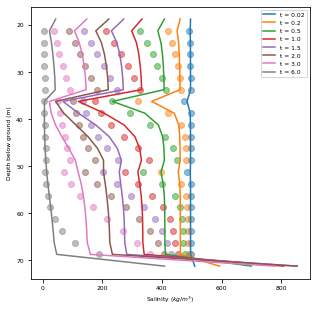

In [ ]:
fig = plt.figure(figsize=(5, 5))

import matplotlib.colors as mcolors

colours = mcolors.TABLEAU_COLORS


x = 0
for col in prof.columns[1:]:
    plt.plot(prof[col], prof['Depth [L]'], label=col, )
        
    plt.scatter(meas.iloc[:,x+1], meas.iloc[:,x+0],  marker = 'o', alpha=0.5)
    x+=2

plt.ylabel('Depth below ground (m)')
plt.xlabel('Salinity ($kg/m^3)$')
plt.legend()

plt.gca().invert_yaxis()